In [1]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import string
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2

from rnn import RNN, PrepareData

torch.cuda.is_available()

True

In [2]:
#input_dim = 7
hidden_dim = 100 # just to test! should have 30
num_layers = 1 # just to test! should have 2
seq_size = 25
all_letters = string.printable
n_letters = len(all_letters)

In [3]:
dataset = PrepareData('input.txt', seq_size, val_ratio=0.2)
#dataset = PrepareData('sample-music2.txt', seq_size)
train_data, val_data = dataset.dataset()

In [4]:
def inputTensor(line):
    if len(line) == 1:
        tensor = torch.zeros(1, n_letters)
        tensor[0, all_letters.find(line[0])] = 1
    else:
        tensor = torch.zeros(len(line)-1, n_letters)
        for idx, letter in enumerate(line[:-1]):
            tensor[idx, all_letters.find(letter)] = 1
    return Variable(tensor.cuda())
        
def targetTensor(line):
    letter_indexes = [all_letters.find(letter) for letter in line[1:]]
    return Variable(torch.LongTensor(letter_indexes).cuda())

def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [5]:
# model = RNN(n_letters, hidden_dim, num_layers=num_layers, output_size=n_letters)
# model = model.cuda()
criterion = nn.CrossEntropyLoss()

In [6]:
def visualize(optimizer_name, results):
    for epoch_losses in results:
        epoch_losses = np.array(epoch_losses)
        plt.plot(np.arange(epoch_losses.shape[0]), epoch_losses)
    plt.legend(['train loss','valid loss'], loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss - Epoch for '+optimizer_name)
    plt.show()

# Different Optimizer 

In [7]:
for optimizer_name, optimizer in zip(['RMSProp', 'Adagrad', 'Adam'], 
                                     [torch.optim.RMSprop,
                                      torch.optim.Adagrad,
                                      torch.optim.Adam]):
    model = RNN(n_letters, hidden_dim, num_layers=num_layers, output_size=n_letters)
    model = model.cuda()
    optimizer = optimizer(model.parameters(), lr=1e-3)
    n_epochs = 5 # Should be 10
    all_losses = []
    train_epoch_losses = []
    valid_epoch_losses = []

    print_every = 2000
    init_hidden_every = 35

    start_time = time.time()

    for epoch in range(n_epochs):
        train_cnt = 0
        total_loss = 0.

        model.hidden = model.init_hidden()

        for sentence in train_data:
            model.zero_grad()

            loss = 0.
            inputs = inputTensor(sentence)
            targets = targetTensor(sentence)

            preds = model(inputs)
            loss = criterion(preds, targets)

            loss.backward(retain_graph=True)
            optimizer.step()
            total_loss += loss
            train_cnt += 1

            if train_cnt % init_hidden_every == 0:
                model.hidden = model.init_hidden()

            if train_cnt % print_every == 0:
                total_loss /= print_every
                all_losses.append(total_loss)
                uptime = time.time() - start_time
                print('%dm:%ds -- [%d, %d], loss: %f' % (uptime/60, uptime%60, epoch, train_cnt, total_loss.data[0]))
                total_loss = 0
        for cur_data, epoch_losses, name in zip([train_data, val_data], 
                                                [train_epoch_losses, valid_epoch_losses], 
                                                ['train loss: ','valid loss: ']):
            cur_loss = 0.
            for sen in cur_data:
                inputs = inputTensor(sen)
                targets = targetTensor(sen)
                preds = model(inputs)
                cur_loss += criterion(preds, targets)
            cur_epoch_loss = cur_loss/len(cur_data)
            epoch_losses.append(cur_epoch_loss.data[0])
            print(name+'{}'.format(cur_epoch_loss.data[0]))
        save_model(model, 'my_models/{}.model'.format(optimizer_name))
    visualize(optimizer_name,[train_epoch_losses, valid_epoch_losses])

            

1m:9s -- [0, 2000], loss: 2.612280
2m:11s -- [0, 4000], loss: 2.131624
3m:28s -- [0, 6000], loss: 1.801251
4m:42s -- [0, 8000], loss: 1.761626
6m:2s -- [0, 10000], loss: 1.559247
7m:15s -- [0, 12000], loss: 1.543207
8m:33s -- [0, 14000], loss: 1.549005
train loss: 2.628561496734619
valid loss: 3.7088143825531006
11m:30s -- [1, 2000], loss: 1.843365
12m:40s -- [1, 4000], loss: 1.752508
13m:50s -- [1, 6000], loss: 1.481674
15m:10s -- [1, 8000], loss: 1.496750
16m:26s -- [1, 10000], loss: 1.379553
17m:38s -- [1, 12000], loss: 1.392747
18m:48s -- [1, 14000], loss: 1.405528
train loss: 2.4761388301849365
valid loss: 3.559746503829956
21m:50s -- [2, 2000], loss: 1.679240
23m:4s -- [2, 4000], loss: 1.619194
24m:21s -- [2, 6000], loss: 1.389743
25m:38s -- [2, 8000], loss: 1.406823
26m:50s -- [2, 10000], loss: 1.312166
28m:1s -- [2, 12000], loss: 1.322444
29m:12s -- [2, 14000], loss: 1.339387
train loss: 2.4272992610931396
valid loss: 3.553565740585327
32m:12s -- [3, 2000], loss: 1.610760
33m:2

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503968623488/work/torch/lib/THC/generic/THCStorage.cu:66

In [8]:
def test(start_with, max_length):
    model.hidden = model.init_hidden()
    seq = str(start_with)
    idx = []
    
    if len(start_with) > 1:
        inputs = inputTensor(seq)
        output = model(inputs)
    
    inputs = inputTensor(seq[-1])
    
    for i in range(max_length):
        output = model(inputs)
        #pr = F.softmax(output.data, 1)  //pytorch 3.0+
        pr = F.softmax(output.data)
        pr = pr.cpu().data.numpy().squeeze()
        pred = np.random.choice(n_letters, 1, p=pr)
        
        seq += all_letters[pred[0]]
        idx.append(pred[0])
        inputs = inputTensor(seq[-1])
    return seq, idx

def teacher_forcing_test(sentence):
    inputs = inputTensor(sentence)
    output = model(inputs)
    _, preds = torch.max(output.data, 1)
    seq = [all_letters[pred] for pred in preds ]
    return ''.join(seq)

In [9]:
def heat_test(start_with, max_length):
    model.hidden = model.init_hidden()
    seq = str(start_with)
    idx = []
    hiddens = []
    
    if len(start_with) > 1:
        inputs = inputTensor(seq)
        output = model(inputs)
    
    inputs = inputTensor(seq[-1])
    
    for i in range(max_length):
        output = model(inputs)
        #pr = F.softmax(output.data, 1)  //pytorch 3.0+
        pr = F.softmax(output.data)
        pr = pr.cpu().data.numpy().squeeze()
        pred = np.random.choice(n_letters, 1, p=pr)
        
        seq += all_letters[pred[0]]
        hiddens.append(model.hidden[0].data.cpu().numpy()[0][0][0])
        idx.append(pred[0])
        inputs = inputTensor(seq[-1])
    return seq, idx, hiddens

In [10]:
seq, idx, hiddens = heat_test('#', 900)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503968623488/work/torch/lib/THC/THCTensorCopy.cu:204

In [ ]:
np_hiddens = np.array(hiddens).reshape(30,30)

In [ ]:
title = "Heatmap for Hidden Activation"
xlabel= "Timeshift"
ylabel="Scales"
import string

def heat_visualization(text, weights):
    plt.figure(figsize=(15, 15))
    plt.title(title)
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    print(np.min(weights))
    print(np.max(weights))
    c = plt.pcolor(weights, edgecolors='k', linewidths=4, cmap='RdBu', vmin=np.min(weights), vmax=np.max(weights))
    print('abc')
    c.update_scalarmappable()
    ax = c.axes
    for p, color, char in zip(c.get_paths(), c.get_facecolors(), text):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, char, ha="center", va="center", color=color, fontsize=20)
    plt.colorbar(c)

text = string.printable
weights =  np.random.rand(1,10)
heat_visualization(seq, np_hiddens)

In [ ]:
test_seq = val_data[99]
start_char = test_seq[:10]

seq, idx = test(start_char, 900)
print('Generated sequence: %s' % (seq))

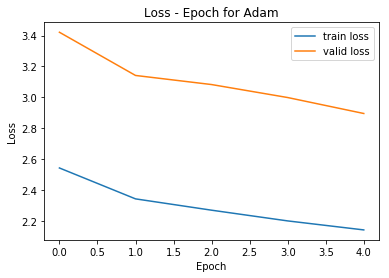

In [7]:
optimizer_name = 'Adam'
adam_train_epoch_losses = [2.54221248626709,2.3419981002807617,2.268646001815796,
                          2.1992461681365967,2.140880823135376]
adam_valid_epoch_losses = [3.4214437007904053, 3.14152455329895,3.082561492919922,
                         2.998465061187744,2.8950817584991455]
visualize(optimizer_name,[adam_train_epoch_losses, adam_valid_epoch_losses])

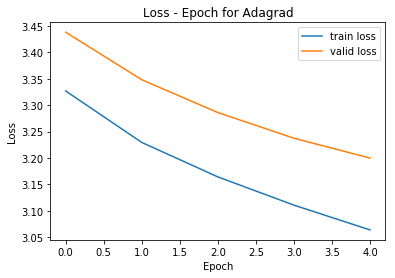

In [8]:
optimizer_name = 'Adagrad'
adagrad_train_epoch_losses = [3.326835870742798,3.2294716835021973,3.1643128395080566,
                             3.1109097003936768,3.0640640258789062]
adagrad_valid_epoch_losses = [3.437840461730957,3.348017692565918,3.2859363555908203,
                            3.2374157905578613,3.1999001502990723]
visualize(optimizer_name,[adagrad_train_epoch_losses, adagrad_valid_epoch_losses])